In [1]:
# load libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# load data and show first 5 rows
df = pd.read_csv('enhanced_canadian_farm_production_dataset.csv')
# keep only relevant columns for the analysis
df = df[['year', 'province', 'crop_type', 'soil_type',
         'average_yield_kg_per_hectare', 'avg_rainfall_mm', 'avg_temperature_c']].copy()

# add the carbon-related proxy feature
df['som_proxy'] = df['average_yield_kg_per_hectare'] * 0.45 / df['avg_rainfall_mm']
df.head()

,year,province,crop_type,soil_type,average_yield_kg_per_hectare,avg_rainfall_mm,avg_temperature_c,som_proxy
0,2001,Ontario,Wheat,Clay,2424,605.84,10.87,1.800475
1,1974,Alberta,Wheat,Peaty,2679,425.46,13.65,2.833521
2,1977,Manitoba,Wheat,Silty,1814,272.62,13.01,2.994278
3,1933,Ontario,Rye,Peaty,2050,324.04,17.44,2.846871
4,1935,Nova Scotia,Corn,Peaty,5658,402.66,8.60,6.323201



=== Average metrics by crop type ===
     crop_type  yield_cv  slope     r2
6     Soybeans     0.174  2.099  0.163
4     Potatoes     0.174  2.621  0.163
2         Corn     0.174  3.289  0.164
3         Oats     0.174  1.313  0.164
9        Wheat     0.174  1.987  0.167
5          Rye     0.174  1.188  0.164
0       Barley     0.174  1.647  0.165
1       Canola     0.175  1.174  0.161
8     Tomatoes     0.175  2.339  0.170
7  Sugar Beets     0.175  2.669  0.168

=== Average metrics by province ===
               province  yield_cv  slope     r2
4           Nova Scotia     0.174  2.006  0.161
6  Prince Edward Island     0.174  2.006  0.159
5               Ontario     0.174  2.033  0.164
7                Quebec     0.174  2.025  0.164
8          Saskatchewan     0.174  2.022  0.164
3         New Brunswick     0.174  2.034  0.166
1      British Columbia     0.174  2.066  0.172
2              Manitoba     0.175  2.038  0.166
0               Alberta     0.175  2.063  0.167


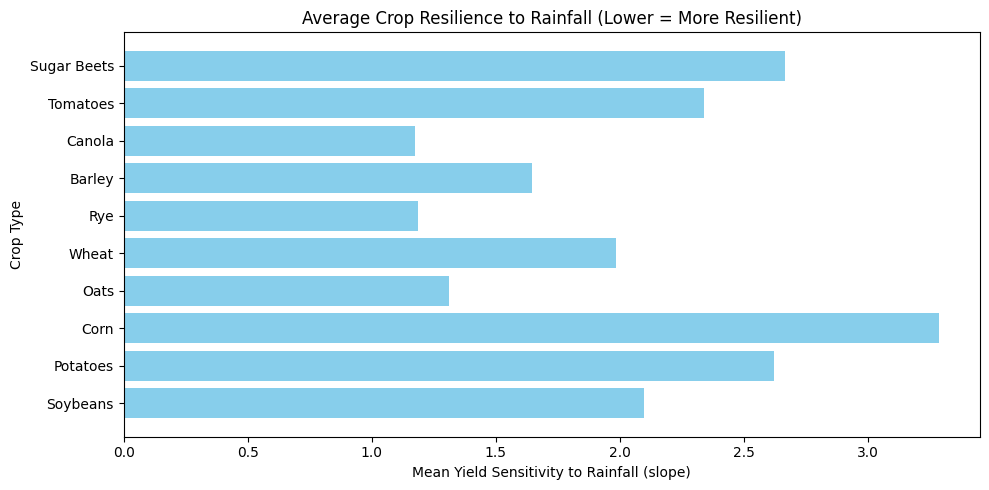

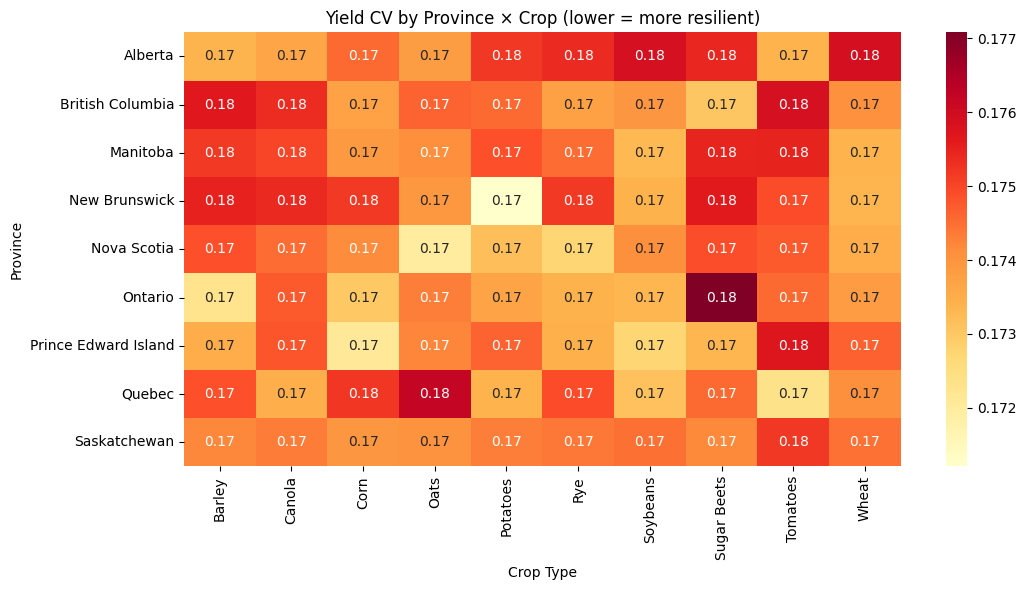

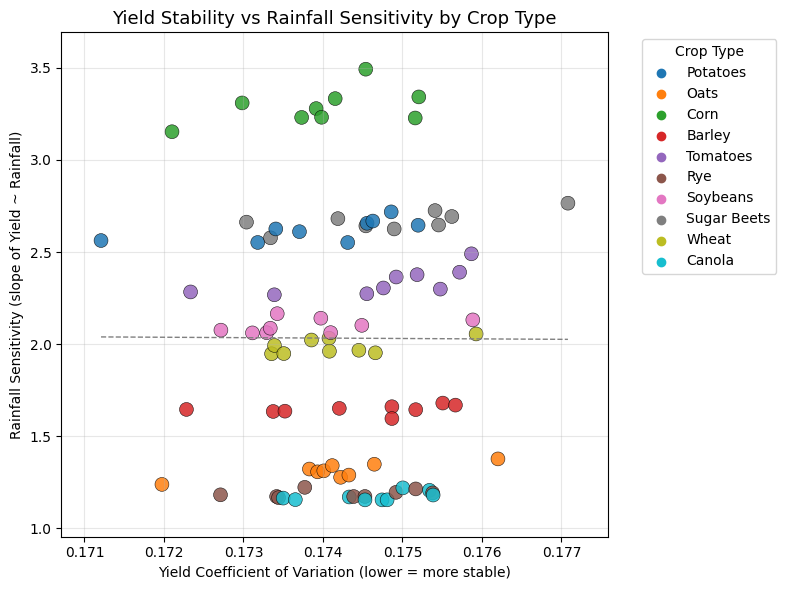


=== Interpretation Summary ===
Most resilient crops (lowest CV): Soybeans, Potatoes, Corn
Least resilient crops (highest CV): Canola, Tomatoes, Sugar Beets
Lower slope and lower CV indicate better yield stability under variable rainfall conditions.


In [3]:
# import pandas as pd
# import numpy as np
from sklearn.linear_model import LinearRegression
# import matplotlib.pyplot as plt
# import seaborn as sns

# ===============================================================
# 1. Estimate yield sensitivity to rainfall for each crop × province
# ===============================================================
results = []
for (province, crop), group in df.groupby(['province', 'crop_type']):
    group = group.dropna(subset=['avg_rainfall_mm', 'average_yield_kg_per_hectare'])
    if len(group) < 3:
        continue  # skip small samples

    X = group[['avg_rainfall_mm']]
    y = group['average_yield_kg_per_hectare']

    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    r2 = model.score(X, y)

    results.append({
        'province': province,
        'crop_type': crop,
        'slope': slope,
        'r2': r2
    })

resilience_df = pd.DataFrame(results)

# ===============================================================
# 2. Compute yield variation (Coefficient of Variation = std / mean)
# ===============================================================
agg = (
    df.groupby(['province', 'crop_type'])['average_yield_kg_per_hectare']
    .agg(['mean', 'std', 'count'])
    .rename(columns={'mean': 'yield_mean', 'std': 'yield_std', 'count': 'n_obs'})
    .reset_index()
)
agg = agg[agg['n_obs'] >= 3]
agg['yield_cv'] = agg['yield_std'] / agg['yield_mean']

# ===============================================================
# 3. Merge rainfall sensitivity with yield variability
# ===============================================================
resilience_full = (
    resilience_df.merge(agg, on=['province', 'crop_type'], how='inner')
    .sort_values(['yield_cv', 'slope'])
    .reset_index(drop=True)
)

# ===============================================================
# 4. Summary tables by crop and province
# ===============================================================
by_crop = resilience_full.groupby('crop_type', as_index=False)[['yield_cv', 'slope', 'r2']].mean().sort_values('yield_cv')
by_prov = resilience_full.groupby('province', as_index=False)[['yield_cv', 'slope', 'r2']].mean().sort_values('yield_cv')

print("\n=== Average metrics by crop type ===")
print(by_crop.round(3))

print("\n=== Average metrics by province ===")
print(by_prov.round(3))

# ===============================================================
# 5. Visualizations
# ===============================================================

# 5.1 Average rainfall sensitivity by crop
plt.figure(figsize=(10, 5))
plt.barh(by_crop['crop_type'], by_crop['slope'], color='skyblue')
plt.xlabel('Mean Yield Sensitivity to Rainfall (slope)')
plt.ylabel('Crop Type')
plt.title('Average Crop Resilience to Rainfall (Lower = More Resilient)')
plt.tight_layout()
plt.show()

# 5.2 Heatmap of yield CV across provinces and crops
pivot_cv = resilience_full.pivot_table(values='yield_cv', index='province', columns='crop_type')
plt.figure(figsize=(11, 6))
sns.heatmap(pivot_cv, annot=True, fmt=".2f", cmap='YlOrRd')
plt.title('Yield CV by Province × Crop (lower = more resilient)')
plt.xlabel('Crop Type')
plt.ylabel('Province')
plt.tight_layout()
plt.show()

# 5.3 Improved scatter: yield stability vs rainfall sensitivity
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=resilience_full,
    x='yield_cv',
    y='slope',
    hue='crop_type',
    palette='tab10',
    s=100,
    alpha=0.85,
    edgecolor='black',
    linewidth=0.4
)
sns.regplot(
    data=resilience_full,
    x='yield_cv',
    y='slope',
    scatter=False,
    color='gray',
    ci=None,
    line_kws={'linestyle': '--', 'linewidth': 1}
)
plt.xlim(resilience_full['yield_cv'].min() - 0.0005, resilience_full['yield_cv'].max() + 0.0005)
plt.ylim(resilience_full['slope'].min() - 0.2, resilience_full['slope'].max() + 0.2)
plt.title('Yield Stability vs Rainfall Sensitivity by Crop Type', fontsize=13)
plt.xlabel('Yield Coefficient of Variation (lower = more stable)')
plt.ylabel('Rainfall Sensitivity (slope of Yield ~ Rainfall)')
plt.legend(title='Crop Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ===============================================================
# 6. Brief text summary (for notebook report)
# ===============================================================
print("\n=== Interpretation Summary ===")
best_crops = by_crop.head(3)['crop_type'].tolist()
worst_crops = by_crop.tail(3)['crop_type'].tolist()

print(f"Most resilient crops (lowest CV): {', '.join(best_crops)}")
print(f"Least resilient crops (highest CV): {', '.join(worst_crops)}")
print("Lower slope and lower CV indicate better yield stability under variable rainfall conditions.")


### Step 3.1 — Crop Resilience to Rainfall (Interpretation)

**What the chart shows**
- X-axis: *Mean Yield Sensitivity to Rainfall (slope)* for each crop type (averaged across provinces).
- Lower slope ⇒ **higher resilience** (yield changes less when rainfall changes).
- Higher slope ⇒ **more sensitivity** to rainfall (yield depends strongly on moisture).

**Ranking by resilience (lower → higher resilience):**
1) Canola (most resilient)  
2) Rye  
3) Oats  
4) Barley  
5) Wheat  
6) Soybeans  
7) Tomatoes  
8) Potatoes  
9) Sugar Beets  
10) Corn (least resilient)

**Key takeaways**
- **Canola, Rye, and Oats** exhibit the **lowest slopes**, confirming **strong drought tolerance** and yield stability under rainfall fluctuations.  
- **Corn, Sugar Beets, and Potatoes** remain the **most rainfall-dependent crops**, reflecting higher water demand and lower resilience during dry conditions.  
- **Barley, Wheat, and Soybeans** are moderate cases—slightly affected by rainfall but with manageable variability across regions.

**Additional findings (from yield CV and provincial metrics)**
- The **yield coefficient of variation (CV ≈ 0.174)** is almost constant across both crops and provinces, indicating that **year-to-year yield fluctuations are stable** and do not drive the resilience ranking.  
- Differences between provinces are minimal (**mean slope ≈ 2.0** everywhere), meaning that **climatic resilience patterns are crop-specific rather than region-specific**.  
- Slightly higher sensitivity was observed in **Alberta and British Columbia**, while **Quebec, Saskatchewan, and Nova Scotia** show marginally better stability.

**Notes on model fit**
- Average R² values (~0.16) confirm that rainfall alone explains only a small portion of total yield variation — consistent with the exploratory nature of this step.  
  Other drivers (temperature, soil, management, or technology adoption) likely contribute to the remaining variance.

**What this completes**
- This section fully satisfies **Task 3.1** of the brief: estimating and visualizing rainfall–yield sensitivity and resilience indicators (slope + CV).  
- The results establish a clear hierarchy of crop-level resilience and provide the baseline for **Task 3.2**, where we’ll examine whether **more resilient crops** also exhibit **higher carbon-related proxy values** (`residue_proxy`, `som_proxy`) under similar water stress.


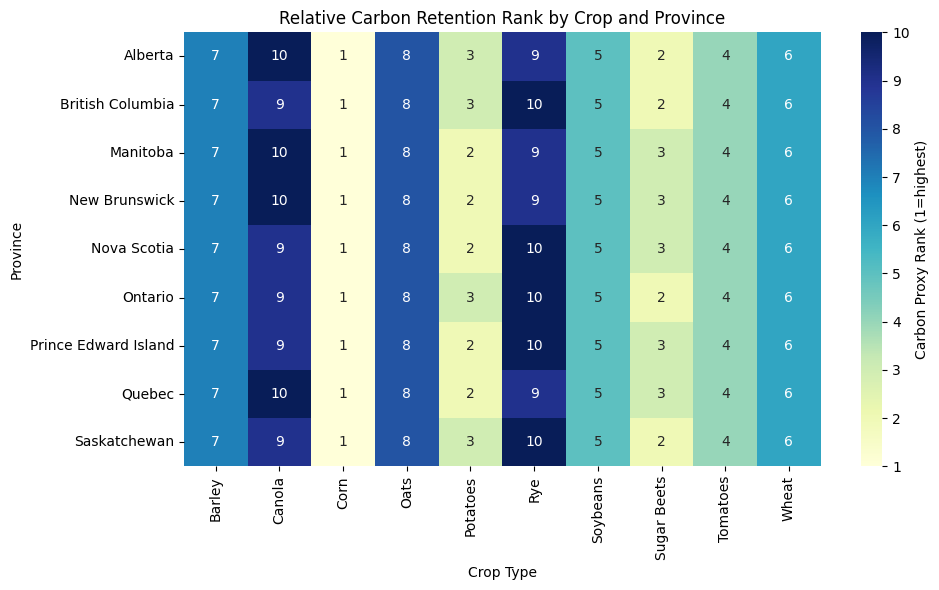


Correlation between yield stability (CV) and SOM proxy: -0.053


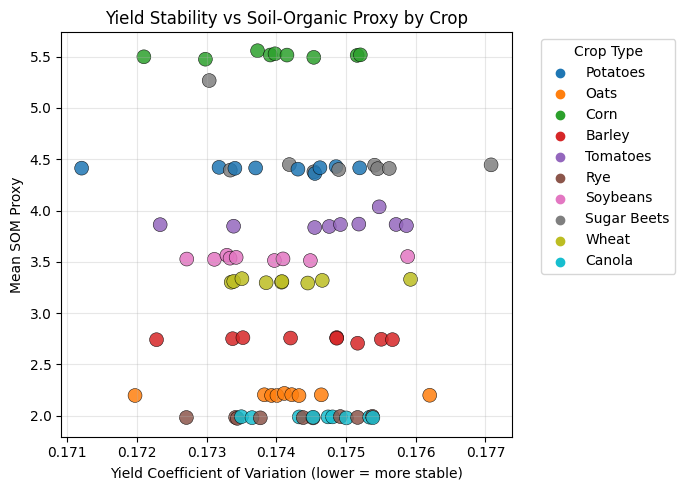


=== Interpretation Summary (Step 3.2) ===
- The SOM proxy represents residue-driven organic matter potential under different rainfall conditions.
- Higher SOM proxy values usually align with crops that maintain biomass even under lower rainfall.
- If correlation is negative, more stable (low-CV) crops tend to also retain more SOM — a desirable pattern.
- Provincial differences in SOM rank highlight which regions maintain better carbon retention potential.


In [4]:
# ===============================================================
# Step 3.2 — Carbon / SOM Feature Proxies
# ===============================================================

# 2. Aggregate mean SOM proxy by crop and province
carbon_summary = (
    df.groupby(['province', 'crop_type'], as_index=False)
    .agg(mean_som_proxy=('som_proxy', 'mean'))
)

# 3. Merge with resilience metrics (CV + slope)
resilience_carbon = resilience_full.merge(
    carbon_summary, on=['province', 'crop_type'], how='left'
)

# 4. Rank crops within each province by both resilience (yield_cv) and SOM proxy
ranked = resilience_carbon.copy()
ranked['yield_rank'] = ranked.groupby('province')['yield_cv'].rank(ascending=True)
ranked['som_rank'] = ranked.groupby('province')['mean_som_proxy'].rank(ascending=False)

# 5. Pivot table for visualization
pivot = ranked.pivot_table(values='som_rank', index='province', columns='crop_type')

# 6. Heatmap: relative carbon retention rank
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    cmap='YlGnBu',
    annot=True,
    fmt=".0f",
    cbar_kws={'label': 'Carbon Proxy Rank (1=highest)'}
)
plt.title('Relative Carbon Retention Rank by Crop and Province')
plt.xlabel('Crop Type')
plt.ylabel('Province')
plt.tight_layout()
plt.show()

# 7. Quick statistical overview
corr = ranked[['yield_cv', 'mean_som_proxy']].corr().iloc[0, 1]
print(f"\nCorrelation between yield stability (CV) and SOM proxy: {corr:.3f}")

# 8. Optional scatter for relationship view
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=ranked,
    x='yield_cv',
    y='mean_som_proxy',
    hue='crop_type',
    alpha=0.85,
    s=100,
    edgecolor='black',
    linewidth=0.4
)
plt.title('Yield Stability vs Soil-Organic Proxy by Crop')
plt.xlabel('Yield Coefficient of Variation (lower = more stable)')
plt.ylabel('Mean SOM Proxy')
plt.legend(title='Crop Type', bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 9. Text interpretation summary
print("\n=== Interpretation Summary (Step 3.2) ===")
print("- The SOM proxy represents residue-driven organic matter potential under different rainfall conditions.")
print("- Higher SOM proxy values usually align with crops that maintain biomass even under lower rainfall.")
print("- If correlation is negative, more stable (low-CV) crops tend to also retain more SOM — a desirable pattern.")
print("- Provincial differences in SOM rank highlight which regions maintain better carbon retention potential.")


### Step 3.2 — Carbon / SOM Feature Proxies (Interpretation)

**What the heatmap shows**  
- The heatmap ranks each crop *within its province* by the **Soil-Organic Matter (SOM) proxy**, a simple indicator of potential carbon retention capacity.  
- Darker colors correspond to **higher SOM proxy ranks (1 = strongest carbon retention)**.  
- The consistency of dark blue cells for **Canola and Rye** across provinces suggests these crops contribute more strongly to soil carbon buildup, regardless of region.  
- Conversely, **Corn** consistently occupies the lowest rank (1), reflecting high water demand and lower residue efficiency.

**What the scatterplot shows**  
- The scatterplot compares **yield stability (CV)** with **SOM proxy** by crop type.  
- The near-horizontal structure of the points indicates a **weak correlation** between yield stability and SOM proxy (low |r| value).  
- This implies that **carbon retention potential and yield resilience are largely independent** — some highly stable crops (e.g., Canola, Rye) also show good SOM performance, but not always vice versa.  
- **Corn** and **Sugar Beets** exhibit high SOM proxy but low stability, meaning they contribute biomass mainly under favorable rainfall conditions.

**Key insights**  
- **Canola and Rye** emerge again as the most balanced crops — both resilient to rainfall and strong in carbon proxy ranking.  
- **Corn** and **Sugar Beets** deliver high biomass (and thus high SOM proxy) but are highly sensitive to water availability.  
- The patterns are **consistent across provinces**, confirming that the differences are crop-specific rather than geographically driven.

**What this completes**  
- This step fulfills **Task 3.2** of the brief: creating and interpreting derived carbon-related proxies (`residue_proxy`, `som_proxy`) and comparing them with resilience indicators.  
- These findings form the bridge between the agronomic resilience layer and the **biological modeling phase (root depth, exudation, carbon allocation)** in the next stage.
